In [1]:
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
from itertools import product
import os
import pickle
import pandas as pd

def load_single_summary(chr, dp, gq, laf, haf, work_dir):
    filename = f"{chr}._DP{dp}_GQ{gq}_LAF{laf}_HAF{haf}_.summary.pkl"
    filepath = os.path.join(work_dir, filename)

    summary_15x_list, summary_30x_list, summary_all_list = [], [], []

    if not os.path.exists(filepath):
        return summary_15x_list, summary_30x_list, summary_all_list

    try:
        with open(filepath, 'rb') as f:
            result_dict = pickle.load(f)

        key_base = [f'DP{dp}', f'GQ{gq}', f'LAF{laf}', f'HAF{haf}']
        for platform, summary_list in zip(['15X', '30X', 'ALL'],
                                          [summary_15x_list, summary_30x_list, summary_all_list]):
            key = frozenset(key_base + [platform])
            if key in result_dict:
                summary_df = result_dict[key][2].copy()
                summary_df["PLATFORM"] = platform
                summary_list.append(summary_df)
    except Exception as e:
        print(f"❌ Error in {filename}: {e}")

    return summary_15x_list, summary_30x_list, summary_all_list

def load_summary_tables_parallel(
    chr: str,
    dp_range: range,
    gq_values: list,
    laf_values: list,
    haf_values: list,
    work_dir_base: str,
    max_workers: int = 8
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:

    work_dir = work_dir_base
    param_combinations = list(product(dp_range, gq_values, laf_values, haf_values))

    summary_15x_all, summary_30x_all, summary_all_all = [], [], []

    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(load_single_summary, chr, dp, gq, laf, haf, work_dir): (dp, gq, laf, haf)
            for dp, gq, laf, haf in param_combinations
        }

        for future in tqdm(as_completed(futures), total=len(futures), desc="Loading summaries"):
            s15x, s30x, sall = future.result()
            summary_15x_all.extend(s15x)
            summary_30x_all.extend(s30x)
            summary_all_all.extend(sall)

    return (
        pd.concat(summary_15x_all, ignore_index=True),
        pd.concat(summary_30x_all, ignore_index=True),
        pd.concat(summary_all_all, ignore_index=True)
    )

# 设置参数
chr = "merged"  # 你可以修改为需要的染色体
dp_range = range(1, 31)
gq_values = [10, 20, 30]
laf_values = [0.0, 0.1, 0.15, 0.2, 0.25, 0.3]
haf_values = [1.0, 0.9, 0.85, 0.8, 0.75, 0.7]
work_dir_base = "/LARGE0/gr10478/b37974/Pulmonary_Hypertension/cteph_agp3k/tuning.concordance.rev1/results/05.merge_concordance_vmiss_summary"

summary_15x, summary_30x, summary_all = load_summary_tables_parallel(
    chr=chr,
    dp_range=dp_range,
    gq_values=gq_values,
    laf_values=laf_values,
    haf_values=haf_values,
    work_dir_base=work_dir_base,
    max_workers=6  # ← 你机器的CPU核心数
)

Loading summaries: 100%|██████████| 3240/3240 [03:49<00:00, 14.14it/s]


In [ ]:
# summary_15x.to_csv(f"{chr}_summary_15x.csv", index=False)
# summary_30x.to_csv(f"{chr}_summary_30x.csv", index=False)
# summary_all.to_csv(f"{chr}_summary_all.csv", index=False)
# print("✅ Summary tables saved as CSV files.")

✅ Summary tables saved as CSV files.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from kneed import KneeLocator
from fractions import Fraction

# === Step 1: Identify Pareto Front ===
def find_pareto_front(df, metric1_col, metric2_col, maximize_metric1=True, maximize_metric2=False):
    m1 = df[metric1_col].values
    m2 = df[metric2_col].values
    is_efficient = np.ones(len(df), dtype=bool)
    for i in range(len(df)):
        if is_efficient[i]:
            better_m1 = m1 >= m1[i] if maximize_metric1 else m1 <= m1[i]
            better_m2 = m2 >= m2[i] if maximize_metric2 else m2 <= m2[i]
            strictly_better_m1 = m1 > m1[i] if maximize_metric1 else m1 < m1[i]
            strictly_better_m2 = m2 > m2[i] if maximize_metric2 else m2 < m2[i]
            is_dominated = (better_m1 & better_m2) & (strictly_better_m1 | strictly_better_m2)
            is_dominated[i] = False
            if np.any(is_dominated):
                is_efficient[i] = False
    return pd.Series(is_efficient, index=df.index)

# === Step 2: Kneedle Tradeoff Point Detection ===
def find_kneedle_tradeoff_point(df, x_col, y_col, curve, direction, S, weight_x, weight_y):
    df_unique = df[[x_col, y_col, 'DP', 'GQ', 'LAF', 'HAF']].drop_duplicates().sort_values(by=x_col)
    x = df_unique[x_col].values
    y = df_unique[y_col].values

    kneedle = KneeLocator(x, y, curve=curve, direction=direction, S=S, weight_x=weight_x, weight_y=weight_y)

    if kneedle.knee is not None:
        knee_indices = np.where(x == kneedle.knee)[0]
        if len(knee_indices) > 0:
            knee_index = knee_indices[0]
            return (*df_unique.iloc[knee_index][[x_col, y_col, 'DP', 'GQ', 'LAF', 'HAF']], kneedle)
    return (None, None, None, None, None, None, kneedle)

# === Step 3–5: Main Pipeline ===
def run_pareto_kneedle_pipeline(summary, metric1_col, metric2_col, maximize_metric1, maximize_metric2,
                                 weights, curve, direction):
    # summary[metric1_col] = summary[metric1_col].round(8)
    # summary[metric2_col] = summary[metric2_col].round(8)

    pareto_mask = find_pareto_front(summary, metric1_col, metric2_col, maximize_metric1, maximize_metric2)
    pareto_df_sorted = summary[pareto_mask].sort_values(by=metric2_col if not maximize_metric2 else f"-{metric2_col}")

    plt.close('all')
    fig, axes = plt.subplots(4, 3, figsize=(15, 18))
    
    # === 提取 PLATFORM 主标题 ===
    platform_values = summary['PLATFORM'].unique()
    platform_label = ', '.join(sorted(platform_values))
    fig.suptitle(f"Trade-off Optimization of Genotype Quality in Auto Chr — Platform:{platform_label}",
                 fontsize=14, fontweight='bold', y=1.01)

    for i, weight1 in enumerate(weights):
        weight_x = 1.0
        weight_y = weight1
        ax = axes[i // 3, i % 3]

        x_k, y_k, dp_k, gq_k, laf_k, haf_k, kneedle_obj = find_kneedle_tradeoff_point(
            pareto_df_sorted, x_col=metric2_col, y_col=metric1_col,
            curve=curve, direction=direction, S=1.0,
            weight_x=weight_x, weight_y=weight_y
        )

        ax.scatter(summary[metric2_col], summary[metric1_col], c='lightgray', s=15, label='Dominated Solutions')
        ax.scatter(pareto_df_sorted[metric2_col], pareto_df_sorted[metric1_col], c='red', s=15, label='Nondominated Solutions')
        ax.plot(pareto_df_sorted[metric2_col], pareto_df_sorted[metric1_col], 'r--')

        if x_k is not None:
            ax.scatter(x_k, y_k, color='purple', s=100, marker='D', label='Kneedle Point')

            distances = np.sqrt((summary[metric2_col] - x_k) ** 2 + (summary[metric1_col] - y_k) ** 2)
            nearest_idx = distances.idxmin()
            x_nearest = summary.loc[nearest_idx, metric2_col]
            y_nearest = summary.loc[nearest_idx, metric1_col]

            ax.annotate(
                f"{metric2_col}:{x_nearest:.3%}\n{metric1_col}:{y_nearest:.3%}",
                xy=(x_nearest, y_nearest),
                xytext=(10, -10),
                textcoords='offset points',
                arrowprops=dict(arrowstyle='->', color='gray'),
                fontsize=8,
                bbox=dict(boxstyle="round,pad=0.2", fc="w", ec="gray", alpha=0.7)
            )

            ax.set_title(f"W({metric1_col} / {metric2_col}): {Fraction(weight1).limit_denominator()}\n"
                         f"Recommended: DP={dp_k}, GQ={gq_k}, LAF={laf_k}, HAF={haf_k}", fontsize=10, fontweight='bold')
        else:
            ax.set_title(f"Weight Ratio: {Fraction(weight1).limit_denominator()}\nNo Kneedle Point",
                         fontsize=10, fontweight='bold')

        xlabel_arrow = "↑" if maximize_metric2 else "↓"
        ylabel_arrow = "↑" if maximize_metric1 else "↓"
        ax.set_xlabel(f"{metric2_col} {xlabel_arrow}", fontsize=10)
        ax.set_ylabel(f"{metric1_col} {ylabel_arrow}", fontsize=10)

        ax.xaxis.set_major_formatter(PercentFormatter(1.0))
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.legend(fontsize=8)

    plt.style.use('default')
    plt.tight_layout()
    plt.show()

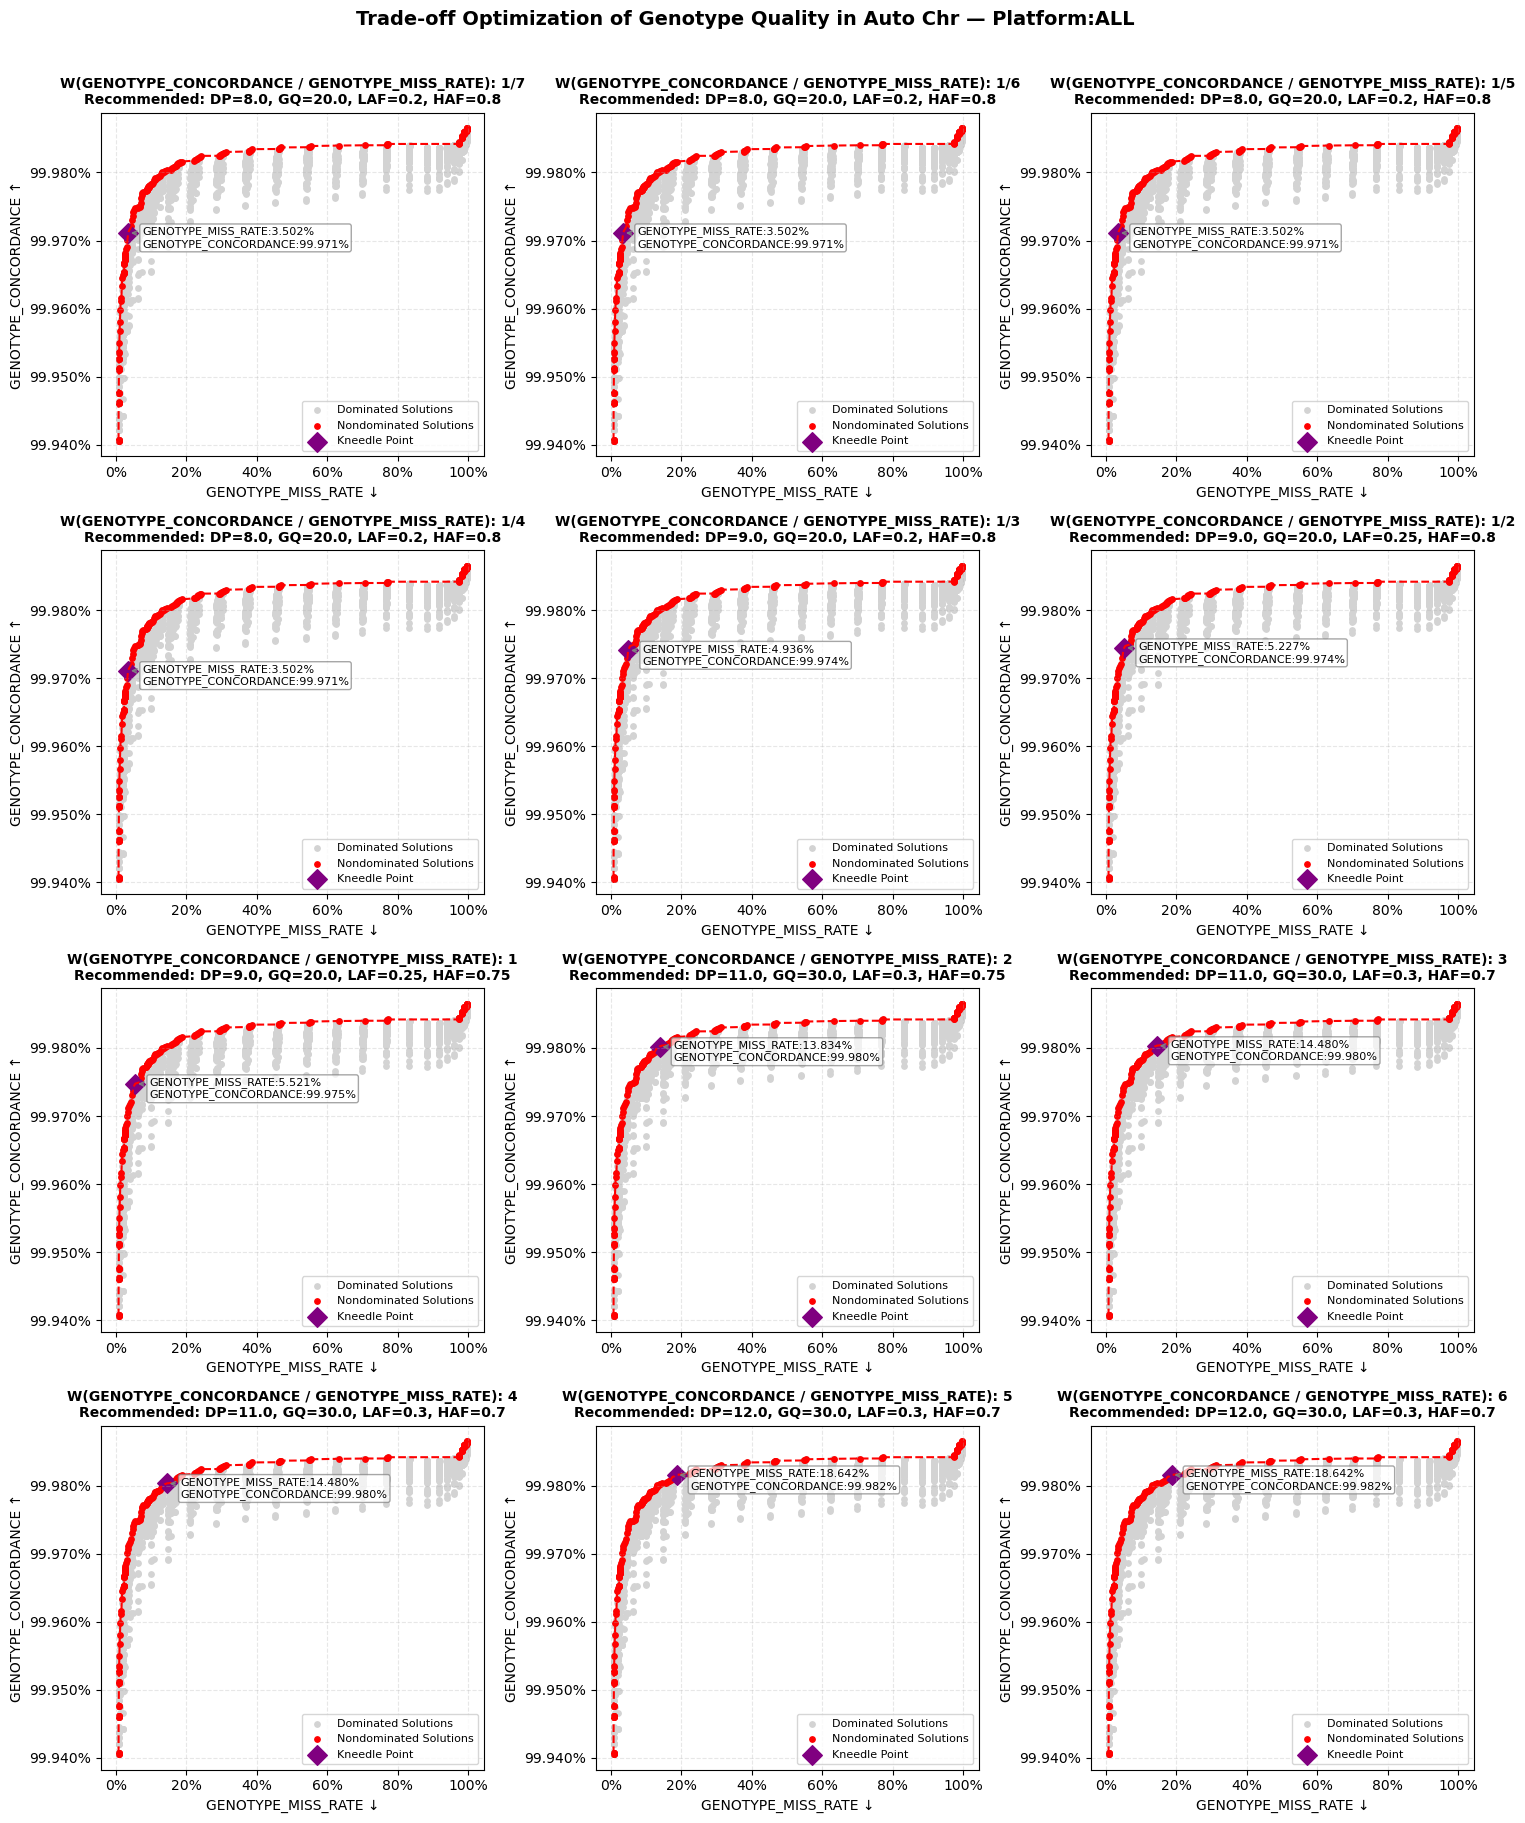

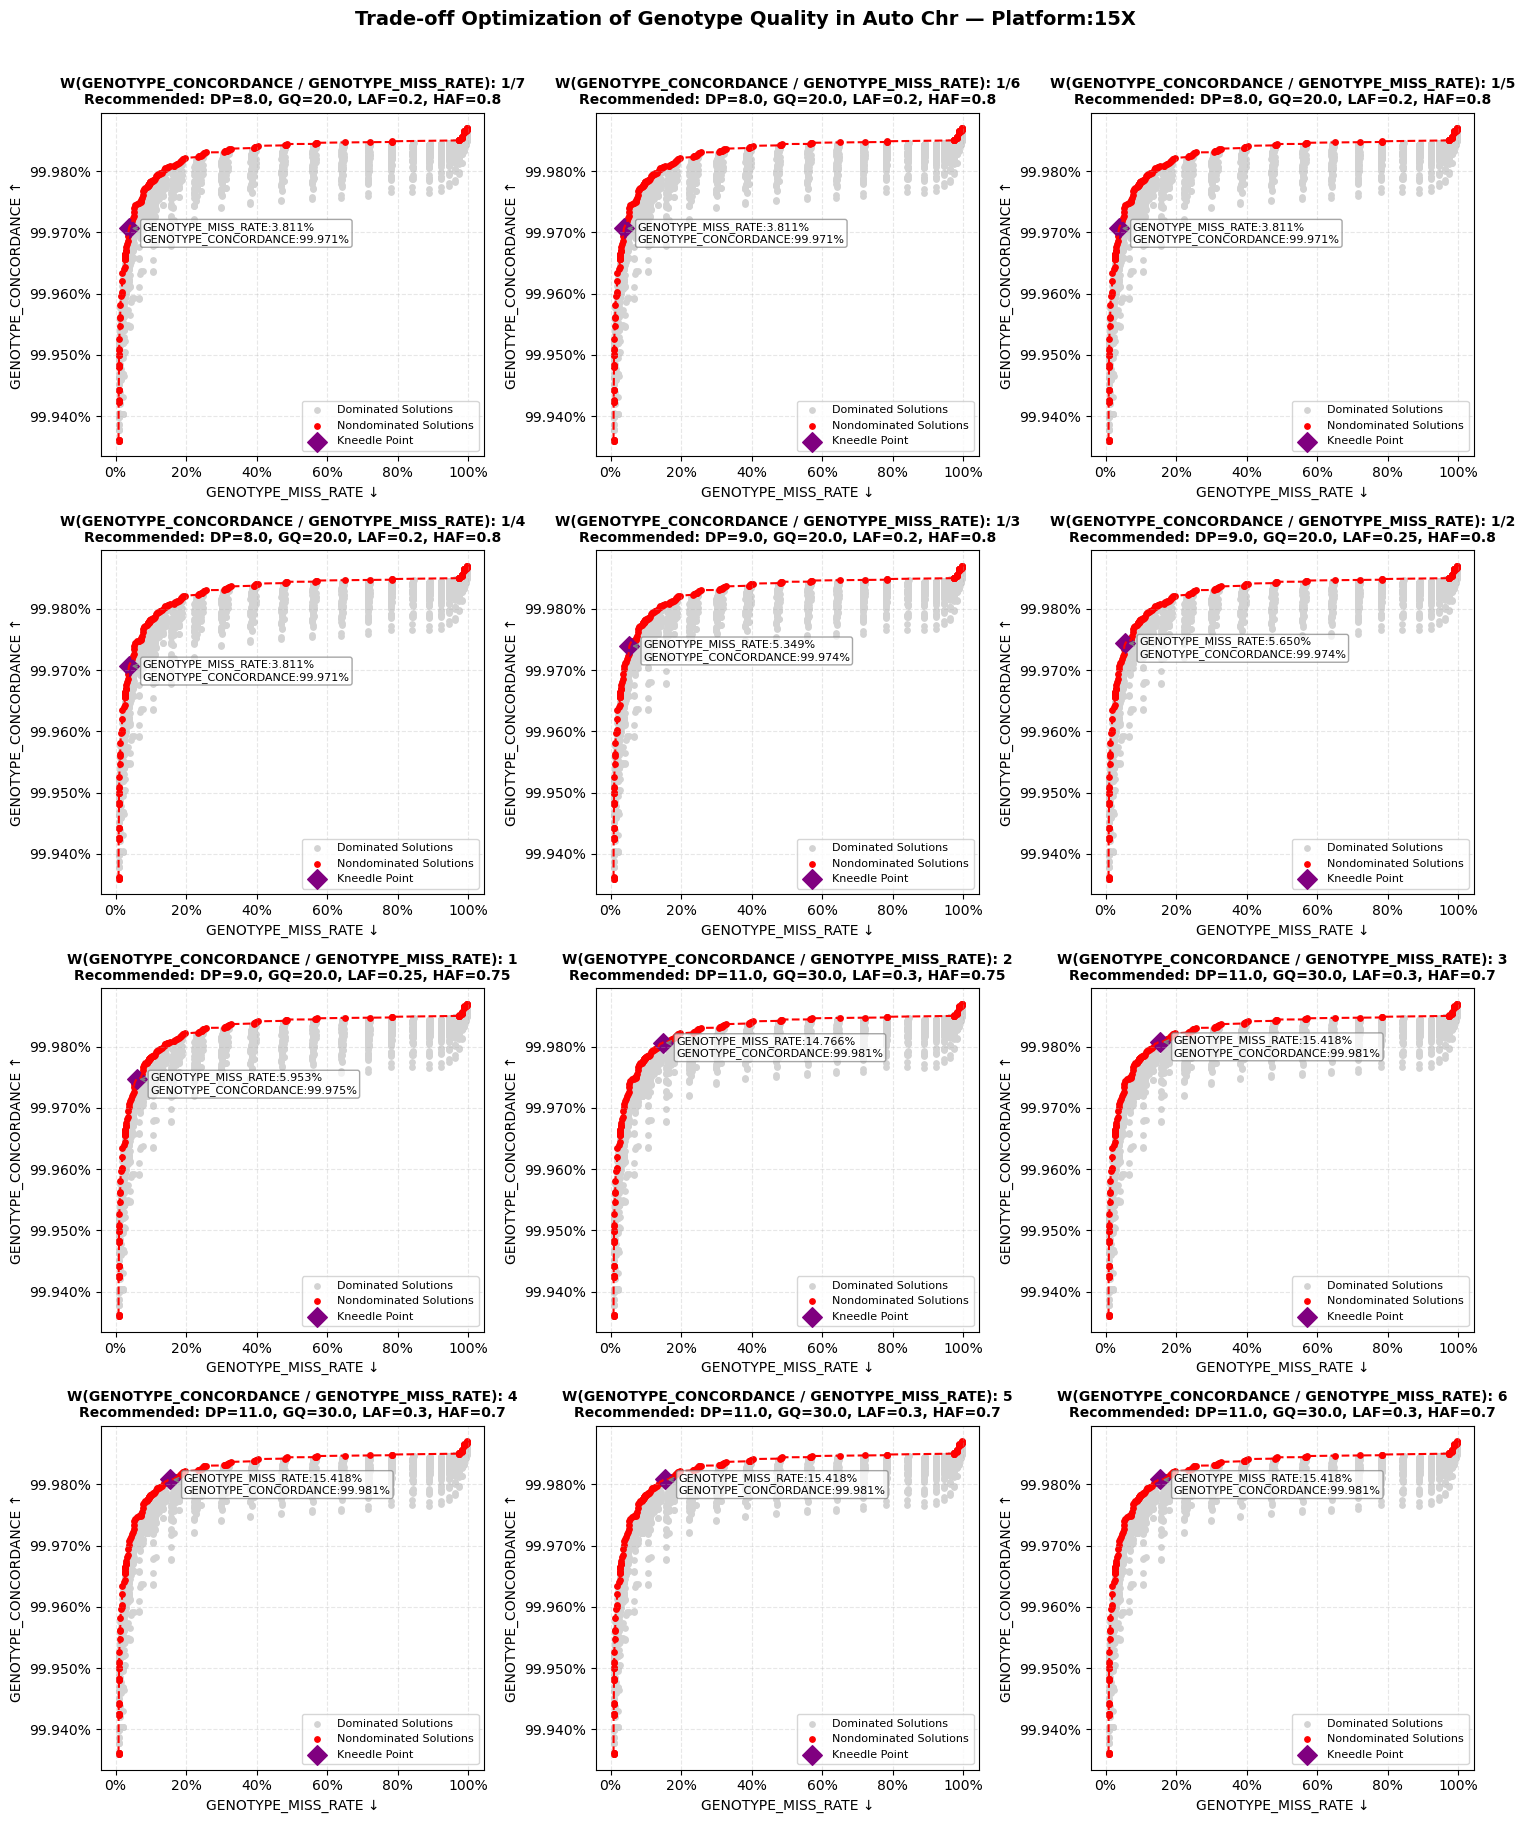

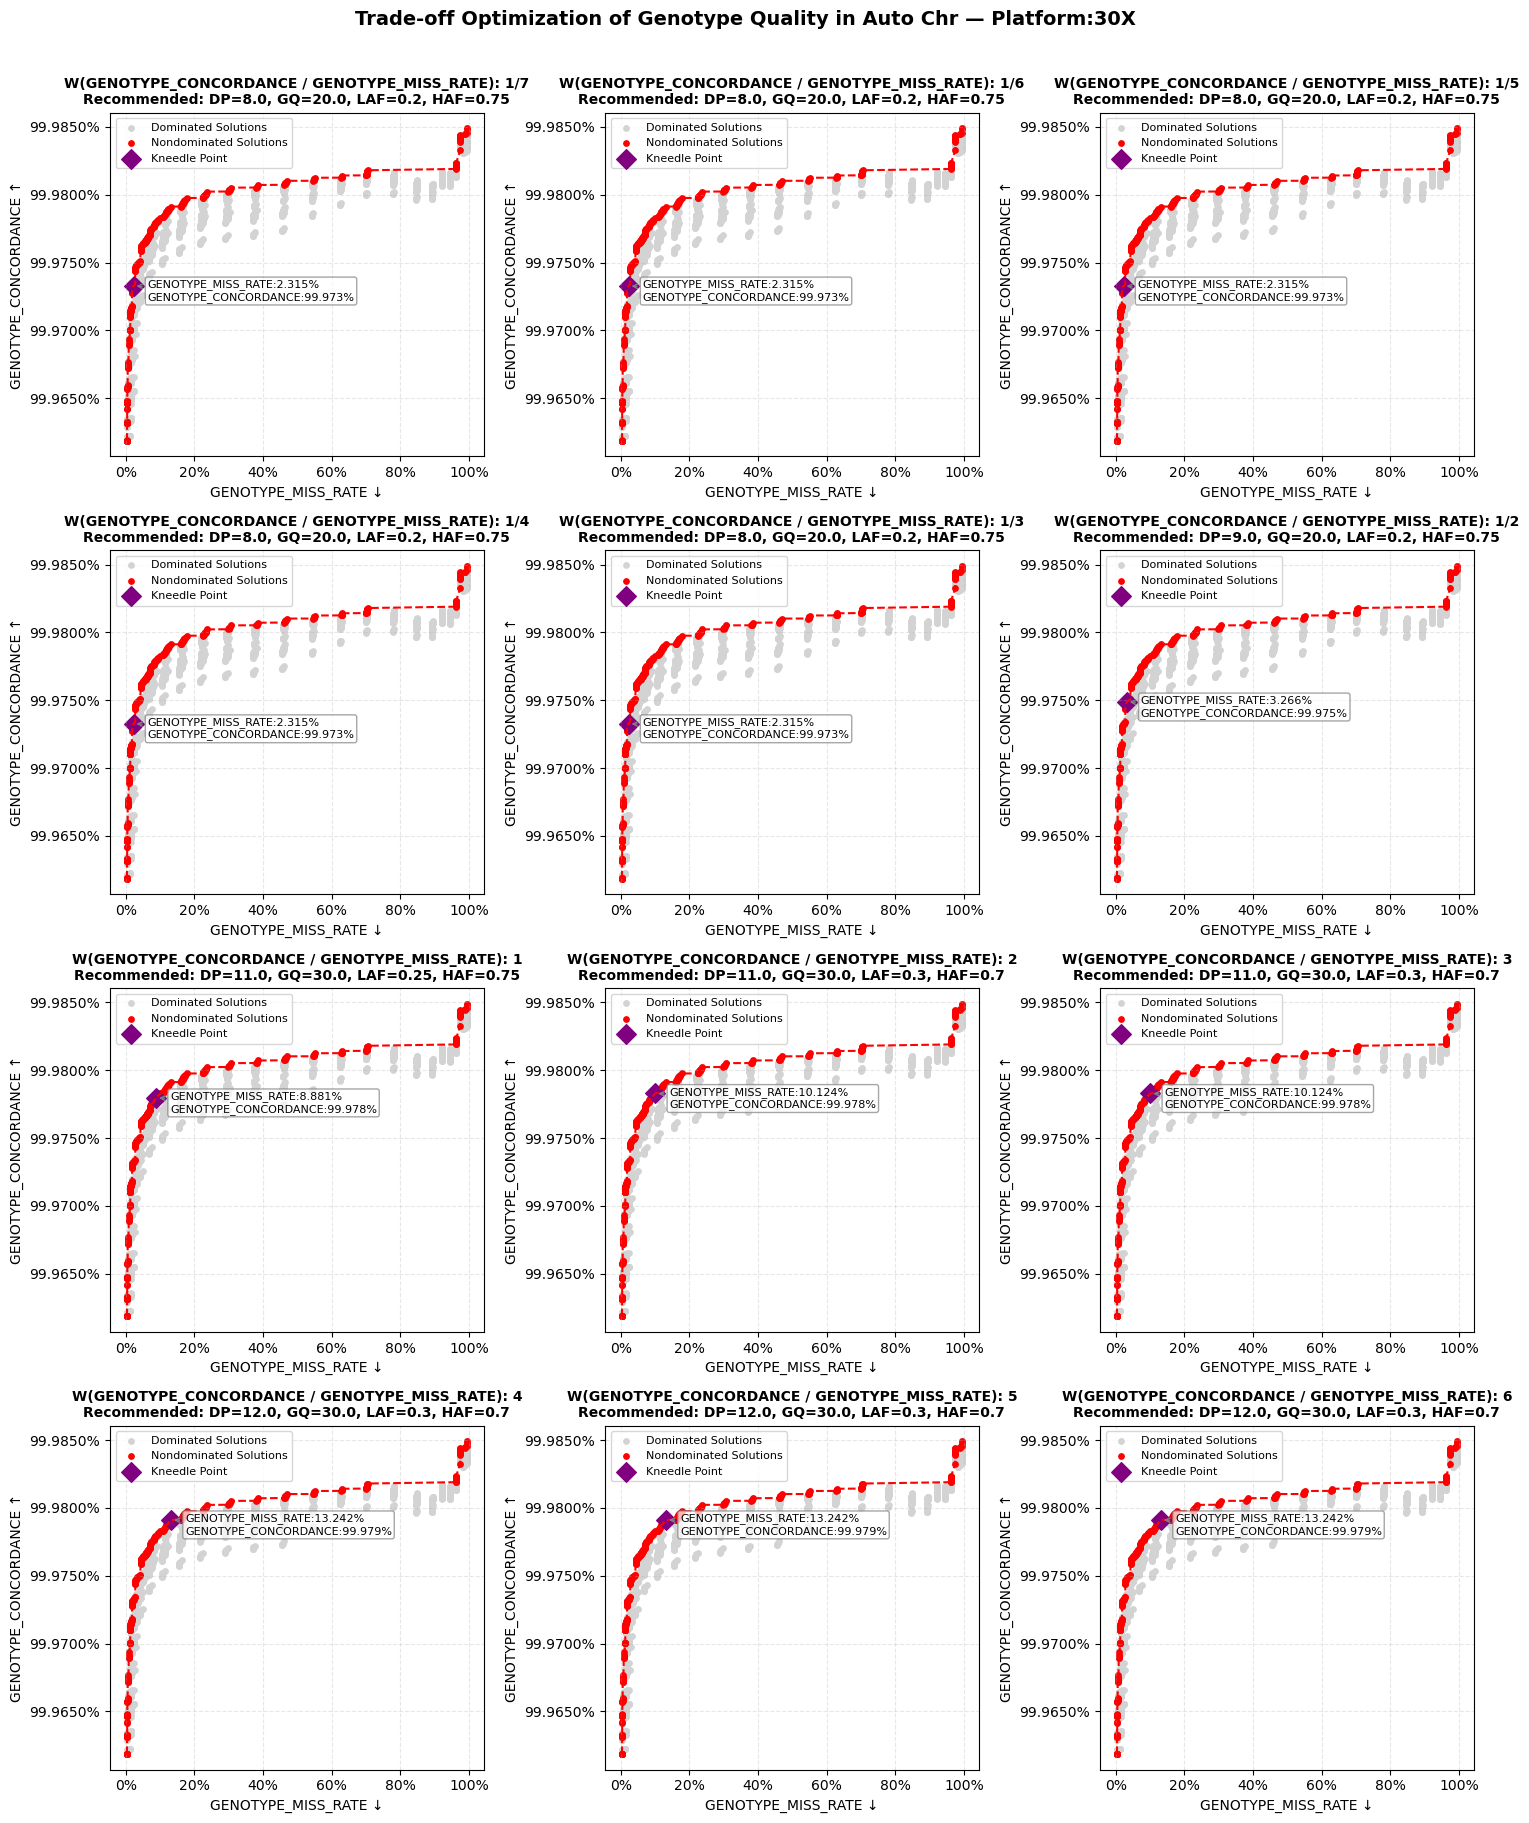

In [8]:
run_pareto_kneedle_pipeline(
    summary=summary_all,
    metric1_col='GENOTYPE_CONCORDANCE',
    metric2_col='GENOTYPE_MISS_RATE',
    maximize_metric1=True,
    maximize_metric2=False,
    weights=[1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 1, 2, 3, 4, 5, 6],
    curve='concave',
    direction='increasing'
)

run_pareto_kneedle_pipeline(
    summary=summary_15x,
    metric1_col='GENOTYPE_CONCORDANCE',
    metric2_col='GENOTYPE_MISS_RATE',
    maximize_metric1=True,
    maximize_metric2=False,
    weights=[1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 1, 2, 3, 4, 5, 6],
    curve='concave',
    direction='increasing'
)

run_pareto_kneedle_pipeline(
    summary=summary_30x,
    metric1_col='GENOTYPE_CONCORDANCE',
    metric2_col='GENOTYPE_MISS_RATE',
    maximize_metric1=True,
    maximize_metric2=False,
    weights=[1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 1, 2, 3, 4, 5, 6],
    curve='concave',
    direction='increasing'
)

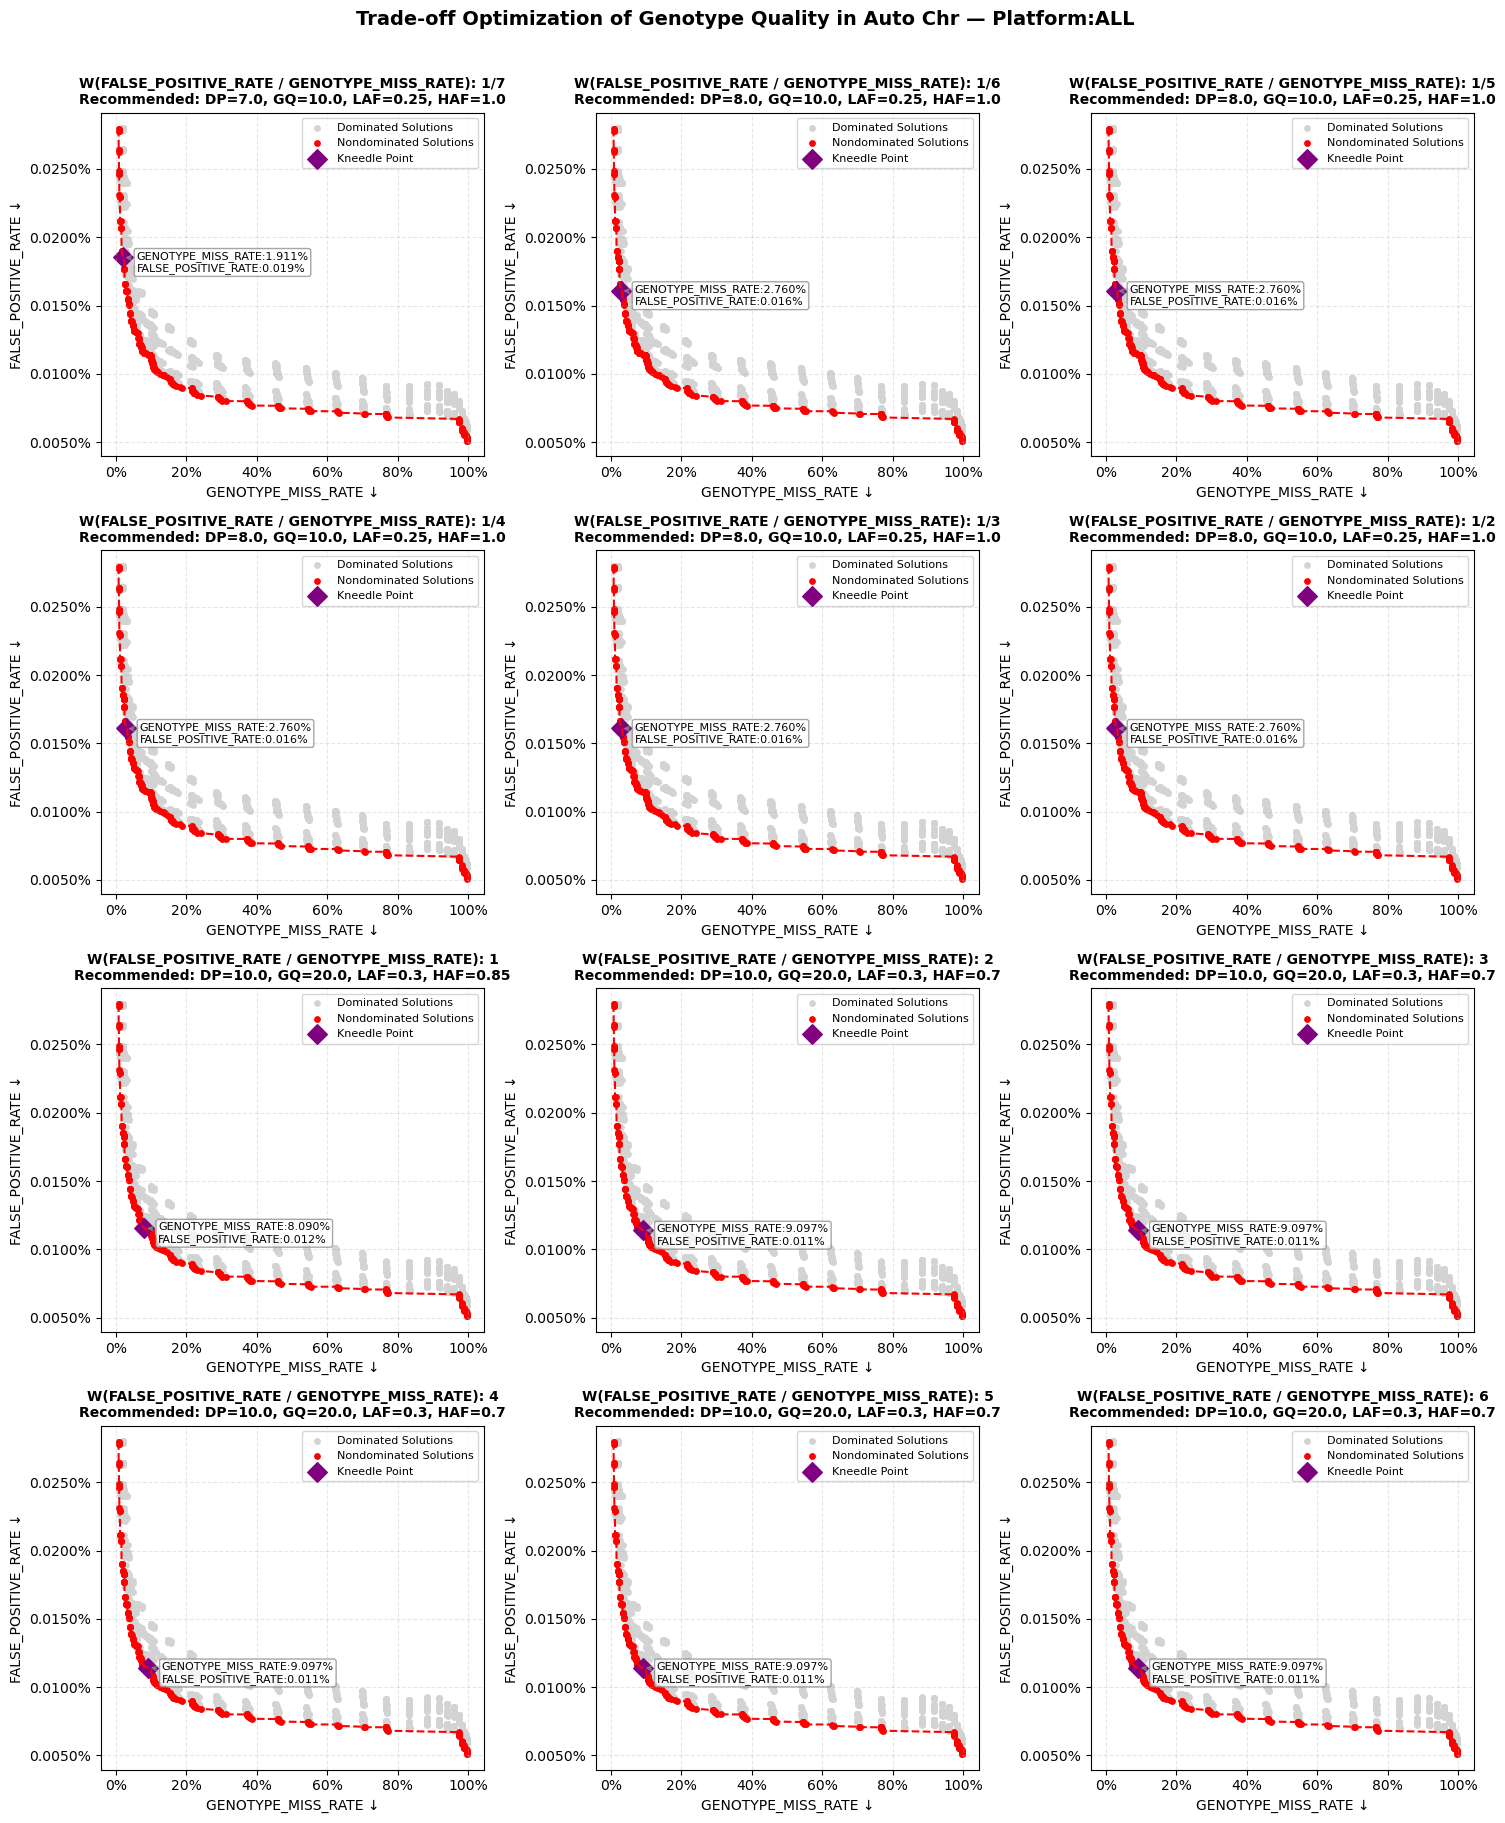

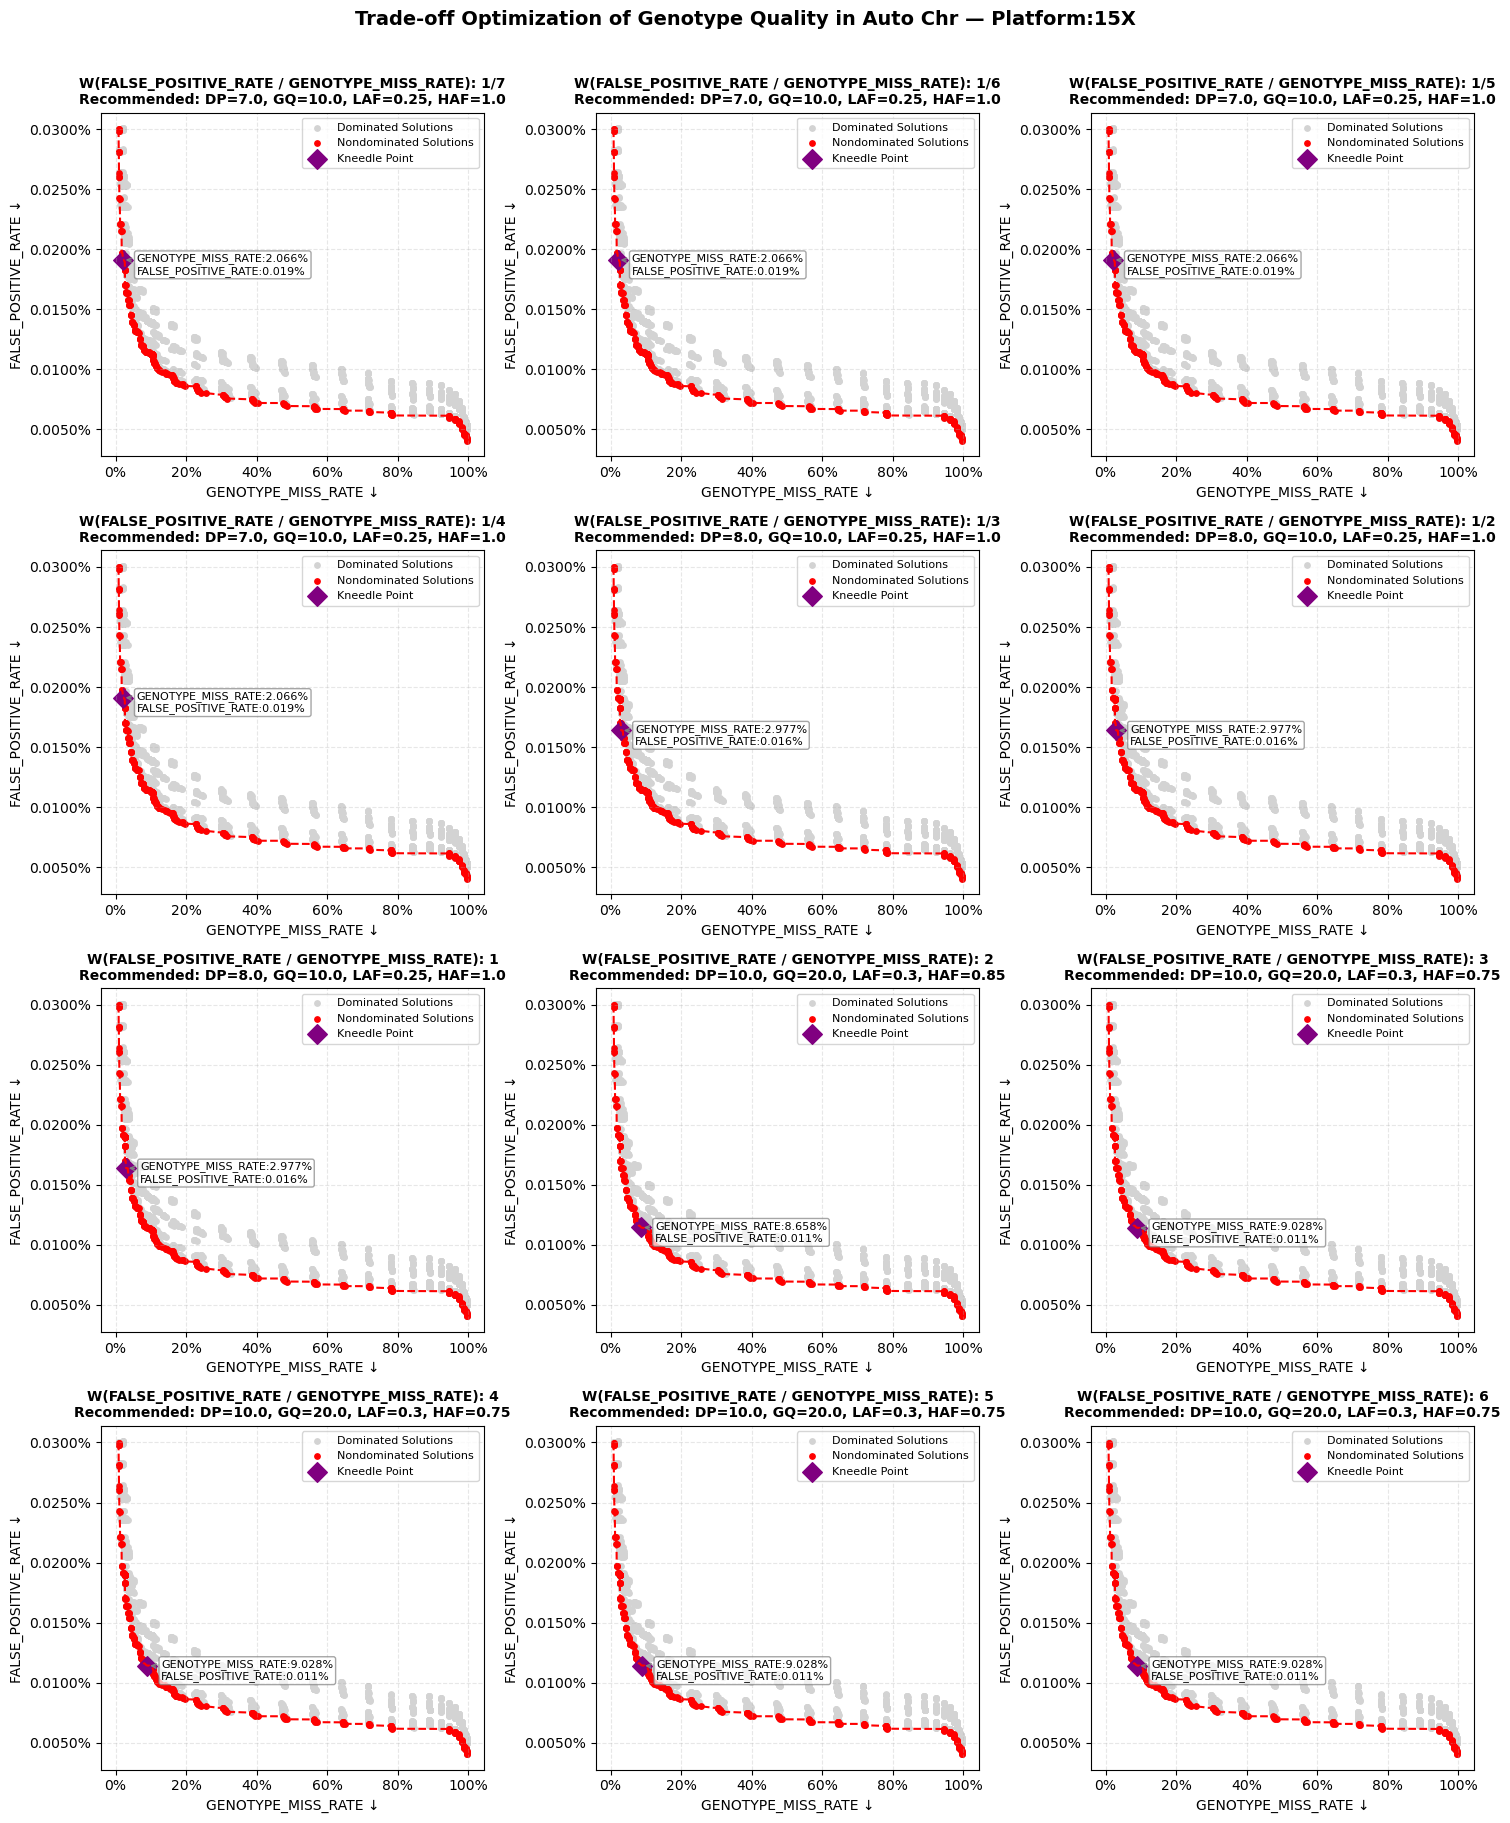

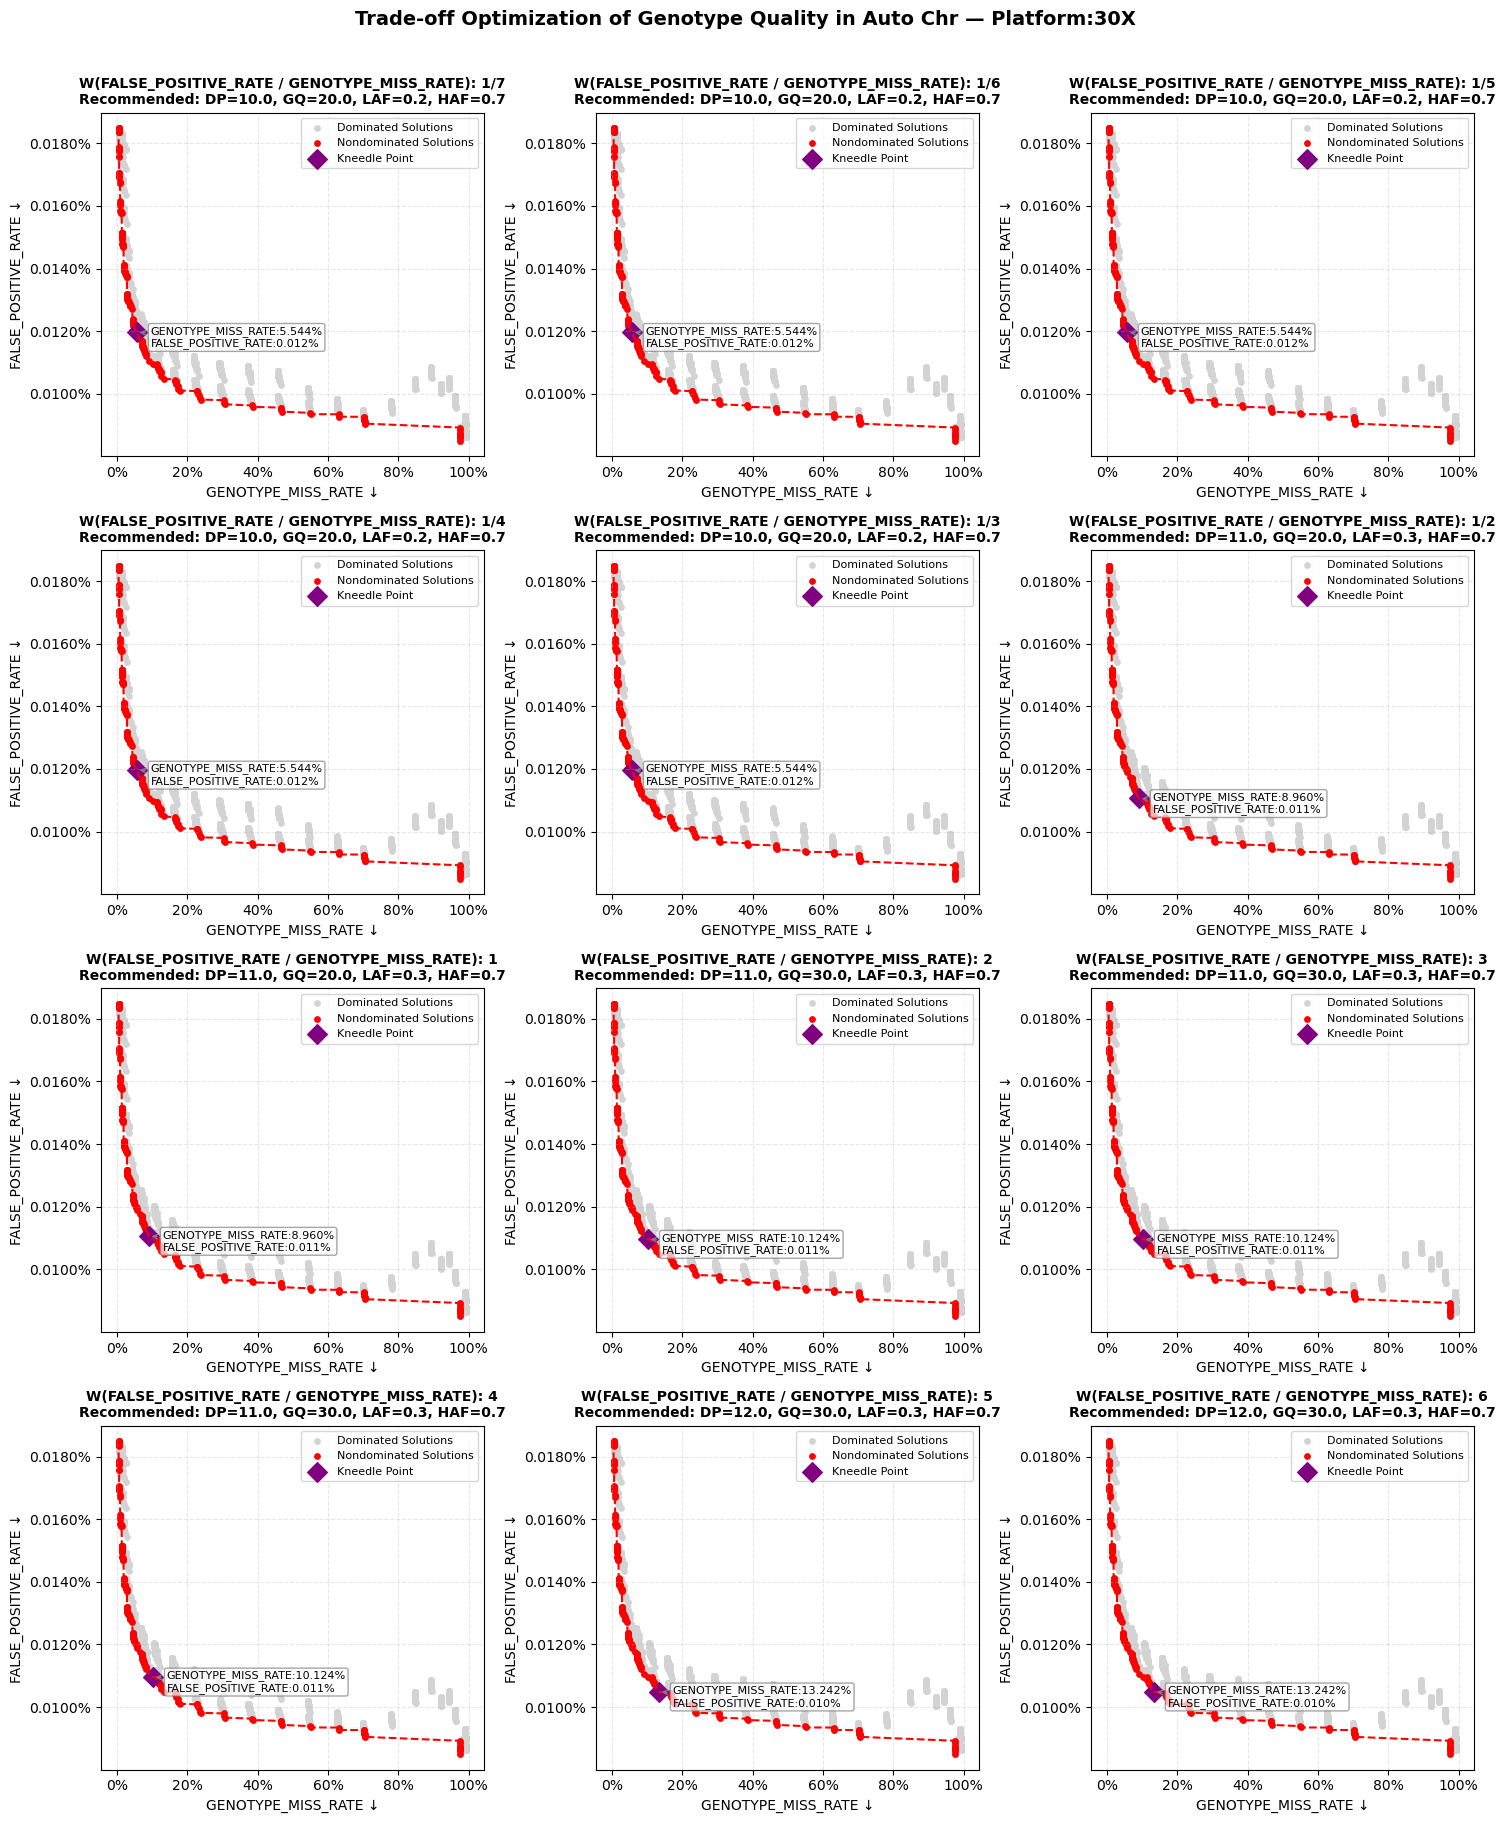

In [9]:
run_pareto_kneedle_pipeline(
    summary=summary_all,
    metric1_col='FALSE_POSITIVE_RATE',
    metric2_col='GENOTYPE_MISS_RATE',
    maximize_metric1=False,
    maximize_metric2=False,
    weights=[1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 1, 2, 3, 4, 5, 6],
    curve='convex',
    direction='decreasing'
)

run_pareto_kneedle_pipeline(
    summary=summary_15x,
    metric1_col='FALSE_POSITIVE_RATE',
    metric2_col='GENOTYPE_MISS_RATE',
    maximize_metric1=False,
    maximize_metric2=False,
    weights=[1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 1, 2, 3, 4, 5, 6],
    curve='convex',
    direction='decreasing'
)

run_pareto_kneedle_pipeline(
    summary=summary_30x,
    metric1_col='FALSE_POSITIVE_RATE',
    metric2_col='GENOTYPE_MISS_RATE',
    maximize_metric1=False,
    maximize_metric2=False,
    weights=[1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 1, 2, 3, 4, 5, 6],
    curve='convex',
    direction='decreasing'
)